# Random Forest Classifier in Python

In this notebook you will find the steps to solve a Random Forest classification problem in python. Despite the fact the methodology used in this problem is not original, the example implementation has been created by [Samuel Miravet-Verde](samuel.miravet@crg.eu). Please, link this repository if you are going to use content from it. 

### Loading packages

In [21]:
%matplotlib inline

import numpy as np
from numpy import genfromtxt, savetxt
import seaborn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cross_validation import StratifiedKFold
from scipy import interp
import matplotlib.pyplot as plt

### Defining datasets

Define the test and training set we are going to use. These datasets has been generated from a real case where we have a binary classifcation problem based on numerical (integer and float) and boolean features. 

In [22]:
#create the training & test sets, skipping the header row with [1:]
dataset = genfromtxt(open('Data/train.csv','r'), delimiter=',', dtype='f8')[1:]    
target = [x[0] for x in dataset]
train = [x[1:] for x in dataset]
test = genfromtxt(open('Data/test.csv','r'), delimiter=',', dtype='f8')[1:]
test = [x[1:] for x in test]

### Generating a toy model dataset

We are going to generate here a dataset to run a toy model, the specifications of the model include 100 estimators, oob_score on (to have ROC AUC measures) and n_jobs=-1 to work with all the cores available in the local machine.

In [23]:
#create and train the random forest
#multi-core CPUs can use: rf = RandomForestClassifier(n_estimators=100, n_jobs=2)
rf = RandomForestClassifier(n_estimators=100, oob_score=1, n_jobs = -1)

### Classifying

To classify we need to fit the model and after we can estore in two different files the classification problem results:

In [24]:
rf.fit(train, target)

savetxt('Data/classes_predicted.csv', rf.predict(test), delimiter=',', fmt='%f')
savetxt('Data/probabil_predicted.csv', rf.predict_proba(test), delimiter=',', fmt='%f')

### Plot the weights of each feature

One of the advantages we have when we use a Random Forest Classifier is that we work with regression and classification tasks. With the regressions we are able to assign a weight to each feature to know which is the one with more relevance in the decission:

In [25]:
l = ['strand', 'bidirectional', 'stem_len', 'loop_len', 'spacer_len','energy', 'mismatched_b', 'GC', 'Ts', 'ptsc1', 'ptsc2', 'distbef', 'distaft']
importances = rf.feature_importances_


for i in range(0, len(l)):
    print(l[i]+' = '+ str(importances[i]))
    
    
# To plot the weights:
std = np.std([importances for tree in rf.estimators_], axis=0)

strand = 0.000297959260833
bidirectional = 0.00306180375902
stem_len = 0.0438066674845
loop_len = 0.00635688022906
spacer_len = 0.0096672744212
energy = 0.124349640075
mismatched_b = 0.0159624979222
GC = 0.0136062052358
Ts = 0.222929408751
ptsc1 = 0.283391488877
ptsc2 = 0.195554158856
distbef = 0.0772507318091
distaft = 0.00376528331876


In [26]:
indices = np.argsort(importances)[::-1]

In [27]:
print("Feature ranking:")
for f in range(0,len(l)-1):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


Feature ranking:
1. feature 9 (0.283391)
2. feature 8 (0.222929)
3. feature 10 (0.195554)
4. feature 5 (0.124350)
5. feature 11 (0.077251)
6. feature 2 (0.043807)
7. feature 6 (0.015962)
8. feature 7 (0.013606)
9. feature 4 (0.009667)
10. feature 3 (0.006357)
11. feature 12 (0.003765)
12. feature 1 (0.003062)


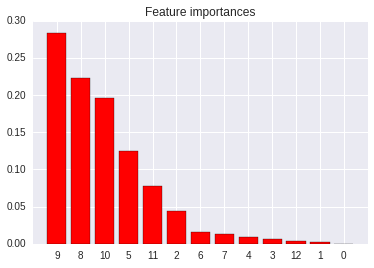

In [28]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(l)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(len(l)), indices)
plt.xlim([-1, len(l)])
plt.show()

### Check the performance of the model

In [35]:
# model = RandomForestClassifier(n_estimators=200, oob_score=1, n_jobs = -1,random_state =50, max_features = "auto", min_samples_leaf = leaf_size)
rf.fit(train, target)
probs = rf.oob_decision_function_
# Transform to labels
labels = [1.0 if y > x else 0 for x, y in probs]

roc_auc_score(target, labels)



(array([ 0.,  1.]), array([ 0.96551724,  1.        ]), array([ 1.,  0.]))

### Plot ROC Curves



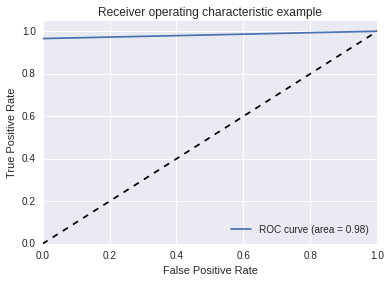

In [37]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(set(labels))):
    fpr[i], tpr[i], _ = roc_curve(target, labels)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

##############################################################################
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[0], tpr[0], label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Try several parameters

In [31]:
sample_leaf_options = [1,5,10,50,100,200,500]

for leaf_size in sample_leaf_options :
    model = RandomForestClassifier(n_estimators = 200, oob_score=1, n_jobs = -1,random_state =50, max_features = "auto", min_samples_leaf = leaf_size)
    model.fit(train, target)
    probs = model.oob_decision_function_
    # Transform to labels
    labels = [1.0 if y > x else 0 for x, y in probs]
    print "AUC - ROC : ", roc_auc_score(target,labels)

AUC - ROC :  0.991379310345
AUC - ROC :  0.991379310345
AUC - ROC :  0.98275862069
AUC - ROC :  0.5
AUC - ROC :  0.5
AUC - ROC :  0.5
AUC - ROC :  0.5
